# ***Importing required Libraries***





In [ ]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE


import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from string import digits
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE



from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

from collections import Counter
import gc


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# ***Connect to kaggle to get the dataset and explore the dataset***



In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                    2030-07-01 23:59:00  Getting Started     Prizes         48           False  
gan-getting-started                             2030-07-01 23:59:00  Getting Started     Prizes         58           False  
store-sales-time-series-forecasting             2030-06-30 23:59:00  Getting Started  Knowledge        588           False  
tpu-getting-started                             2030-06-03 23:59:00  Getting Started  Knowledge         90           False  
digit-recognizer                                2030-01-01 00:00:00  Getting Started  Knowledge       1214           False  
titanic                                         2030-01-01 00:00:00  Getting Started  Knowledge      14348           False  


In [ ]:
!kaggle datasets download -d tboyle10/medicaltranscriptions

  0% 0.00/4.85M [00:00<?, ?B/s]
100% 4.85M/4.85M [00:00<00:00, 88.1MB/s]


In [ ]:
!unzip /content/medicaltranscriptions.zip

Archive:  /content/medicaltranscriptions.zip
  inflating: mtsamples.csv           


In [ ]:
clinical_text_df= pd.read_csv('/content/mtsamples.csv')

In [ ]:
clinical_text_df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
print(clinical_text_df.columns)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


In [ ]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count
    

In [ ]:
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 140208
Number of unique words in transcriptions column: 35805
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

In [ ]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156
============ Reduced Categories ======================


In [ ]:
print('============Reduced Categories Transcription example======================')
i=1
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) + "\n" )
    dataList = dataCategory['transcription'].tolist()
    print('====================================================')
    print('Sample Transcription:\n'+str(dataList[10]) + "\n")
    print('====================================================')
    i = i+1

print('============ Reduced Categories Transcription example======================')

============Reduced Categories Transcription example======================
Cat:1  Cardiovascular / Pulmonary : 371

Sample Transcription:
PREOPERATIVE DIAGNOSIS: , Need for intravenous access.,POSTOPERATIVE DIAGNOSIS: , Need for intravenous access.,PROCEDURE PERFORMED:  ,Insertion of a right femoral triple lumen catheter.,ANESTHESIA: , Includes 4 cc of 1% lidocaine locally.,ESTIMATED BLOOD LOSS: , Minimum.,INDICATIONS:,  The patient is an 86-year-old Caucasian female who presented to ABCD General Hospital secondary to drainage of an old percutaneous endoscopic gastrostomy site.  The patient is also ventilator-dependent, respiratory failure with tracheostomy in place and dependent on parenteral nutrition secondary to dysphagia and also has history of protein-calorie malnutrition and the patient needs to receive total parenteral nutrition and therefore needs central venous access.,PROCEDURE:,  The patient's legal guardian was talked to.  All questions were answered and consent was obtain

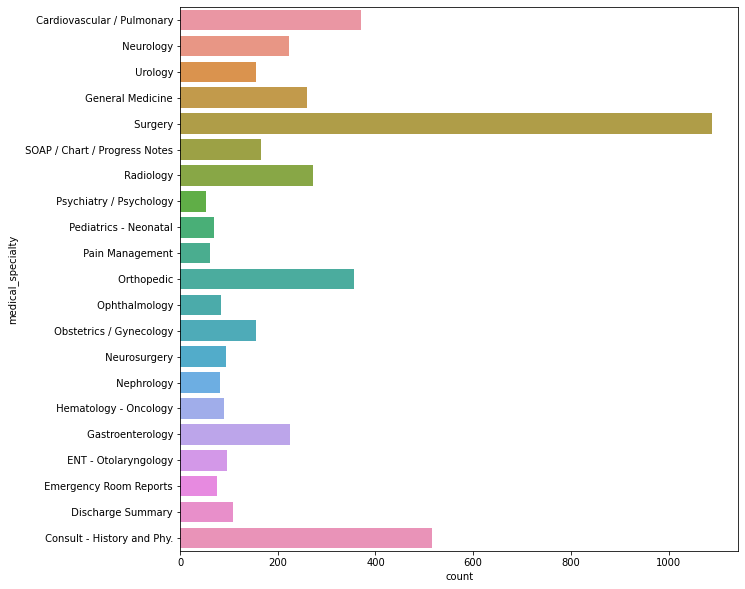

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [ ]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(4597, 2)

In [ ]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely consumes ETOH.,ROS:, I

# ***Data Cleaning***
We will do some basic cleaning such as removing punctuations, stopwords and emojis .So let's start.

In [ ]:
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]


mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'


i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 Consult - History and Phy. : 516
Cat:3 Discharge Summary : 108
Cat:4 ENT - Otolaryngology : 96
Cat:5 Emergency Room Reports : 75
Cat:6 Gastroenterology : 224
Cat:7 General Medicine : 259
Cat:8 Hematology - Oncology : 90
Cat:9 Nephrology : 81
Cat:10 Neurology : 223
Cat:11 Neurosurgery : 94
Cat:12 Obstetrics / Gynecology : 155
Cat:13 Ophthalmology : 83
Cat:14 Orthopedic : 355
Cat:15 Pain Management : 61
Cat:16 Pediatrics - Neonatal : 70
Cat:17 Psychiatry / Psychology : 53
Cat:18 Radiology : 273
Cat:19 SOAP / Chart / Progress Notes : 166
Cat:20 Urology : 156
============Reduced Categories======================


(2324, 2)

In [ ]:
class data_cleaning:

  def __init__(self,df):

    self.df=df
    self.df['transcription'] = self.df['transcription'].apply(lambda x : x.lower())
    self.df['transcription'] = self.df['transcription'].apply(lambda x : self.remove_stopwords(x))
    self.df['transcription']=  self.df['transcription'].apply(lambda x : self.remove_emoji(x))
    self.df['transcription']=  self.df['transcription'].apply(lambda x : self.remove_punct(x))
    self.df['transcription']=  self.df['transcription'].apply(lambda x : self.number_removal(x))

  # Removing the stopwords from text
  def remove_stopwords(self,text):
      final_text = []
      for i in text.split():
          if i.strip().lower() not in stop:
              final_text.append(i.strip())
      return " ".join(final_text)


  # Removing emojis

  def remove_emoji(self,text):
      emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
      return emoji_pattern.sub(r'', text)



  # Removing punctuations


  def remove_punct(self,text):
      table=str.maketrans('','',string.punctuation)
      return text.translate(table)

  # Removing numbers


  def number_removal(self,text):
      remove_digits = str.maketrans('', '', digits)
      return text.translate(remove_digits)

  


  

In [ ]:
data_cleaning_depression = data_cleaning(data)

In [ ]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:cc confusion slurred speechhx  primarily obtained boyfriend  yo rhf experienced flulike illness  weeks prior presentation  weeks prior presentation found passed out bed awoken appeared confused lethargic apparently recovered within  hours two weeks prior presentation demonstrated emotional lability uncharacteristic  outbursts anger inappropriate laughter left stove onshe began slurring speech  days prior admission day presentation developed right facial weakness began stumbling right denied associated headache nausea vomiting fever chills neck stiffness visual change history illicit drugetoh use head traumapmh migraine headachefhx  unremarkableshx divorced lives boyfriend  children alive well denied tobaccoillicit drug use rarely consumes etohros irregular mensesexam bp hr rr  tcms alert oriented name only perseverative thought processes utilized one two word answersphrases nonfluent rarely followed commands impaired writing namecn flattened right nasolabial fold

# ***TF-IDF for Vectorization And PCA for Dimension Reduction***


In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdominal', 'abdominal pain', 'able', 'abnormal', 'abnormalities', 'achieved', 'active', 'activity', 'acute', 'addition', 'additional', 'adequate', 'adhesions', 'administered', 'admission', 'admitted', 'advanced', 'age', 'ago', 'air', 'alcohol', 'alert', 'anastomosis', 'anesthesia', 'anesthetic', 'angiogram', 'ankle', 'anterior', 'anterior cervical', 'anterior descending', 'anteriorly', 'antibiotic', 'antibiotics', 'aorta', 'aortic', 'aortic valve', 'ap', 'appear', 'appearance', 'appeared', 'appears', 'appendix', 'applied', 'applied patient', 'appropriate', 'appropriately', 'approximated', 'approximately', 'approximately cm', 'area', 'areas', 'arm', 'arteries', 'artery', 'artery disease', 'asked', 'aspect', 'aspiration', 'aspirin', 'associated', 'atrial', 'atrial fibrillation', 'attention', 'auscultation', 'away', 'baby', 'balloon', 'base', 'based', 'bed', 'began', 'benefits', 'better', 'bid', 'bilateral', 'bilaterally', 'biopsies', 'biopsy', 'bipolar', 'bit

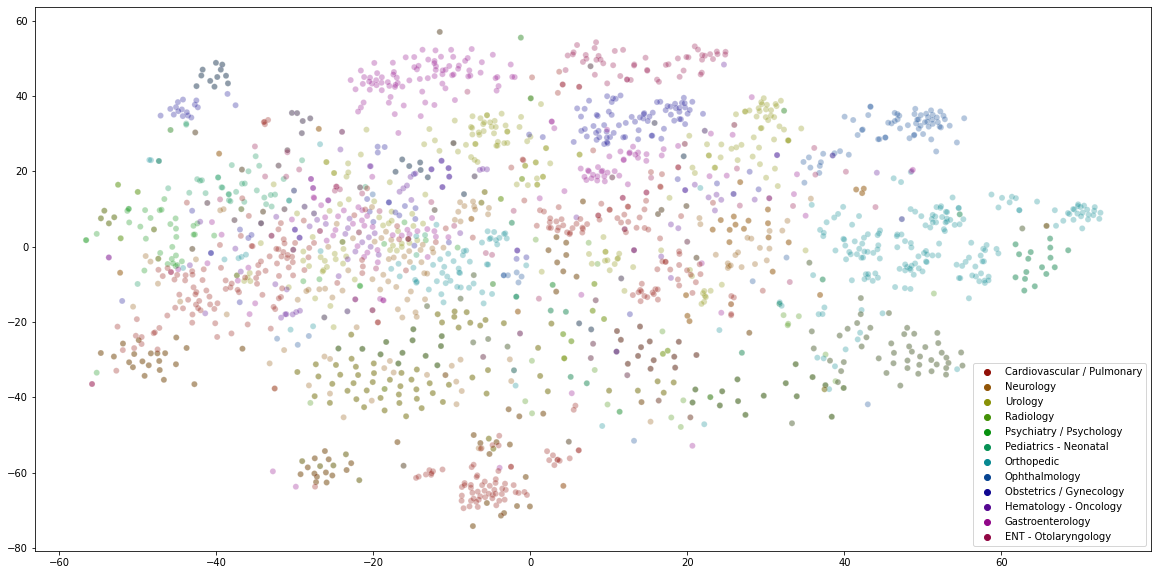

In [ ]:

gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(20,10))
palette = sns.hls_palette(12, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [ ]:

pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()


# ***Machine Learning Models***

In [ ]:




### METHODS TO INITIATE AND EVALUATES ALL MACHINE LEARNING MODELS

def ml_models_defination(): 
    """
    This function consists the models defination for All gram Features
    
    Retuns:
        ml_models: list of models
        model_names: list of model_names
    
    """
    
    lr_model = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1)
    dt_model = DecisionTreeClassifier(criterion = 'gini', random_state=100)
    rf_model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
    #mnb_model = MultinomialNB()
    knn_model = KNeighborsClassifier(n_neighbors=5, metric = 'minkowski')
    psvm_model = SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)
    ksvm_model = SVC(C= 1000,kernel = 'rbf',probability=True, gamma = 0.5)
    adaboost_model = AdaBoostClassifier(n_estimators=500, learning_rate=1, random_state = 1)
    xg_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective ='multi:softprob' )
    gb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=1, random_state = 1)


    model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','Linear SVM','Kernel SVM','Adaboost','XGBoost','Gradient Boosting Classifier']
    
    # Create list of models
    ml_models = [lr_model,dt_model,rf_model,knn_model,psvm_model,ksvm_model,adaboost_model,xg_model,gb_model]
    
    return ml_models,model_names 


                                          #============================================
                                           ####### Model Evaluation Function ############
                                           #=============================================

def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.
    
    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
        
    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100 
    my_dict['Precision'] = round(precision_score(y_test, pred_y,average='macro'),4)*100 
    my_dict['Recall'] = round(recall_score(y_test, pred_y,average='macro'),4)*100 
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y,average='macro'),4)*100 
    
    return my_dict  

                                        #========================================
                                        #### Model Performane into Dataframe #####
                                        #=========================================
            
def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.
    
    Args:
        performance_dict: a dictionary of all the parameters for each models
        
    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    model_names = ['LR','DT','RF','KNN','Polynomial SVM','RBF SVM','AdaBoost','XGBoost','Gradient Boosting Classifier']
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,'Recall':re_list,'F1 Score':f1_list,'Model Name':model_names })
    return performance_df

# ***Model evaluation***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels)

print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1743, 594)
Test_Set_Size:(581, 594)


In [ ]:
# APPLYING AND EVALUATING ALL THE MODELS

ml_models,model_names = ml_models_defination()

accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}

accuracy

{'Logistic Regression': {'Accuracy': 65.92,
  'Precision': 69.28999999999999,
  'Recall': 61.63999999999999,
  'F1 Score': 64.22},
 'Decision Tree': {'Accuracy': 42.86,
  'Precision': 43.769999999999996,
  'Recall': 41.61,
  'F1 Score': 42.13},
 'Random Forest': {'Accuracy': 53.18000000000001,
  'Precision': 56.46,
  'Recall': 48.83,
  'F1 Score': 51.0},
 'Naive Bayes': {'Accuracy': 57.14,
  'Precision': 65.64,
  'Recall': 54.99000000000001,
  'F1 Score': 57.769999999999996},
 'KNN': {'Accuracy': 50.77,
  'Precision': 55.720000000000006,
  'Recall': 42.16,
  'F1 Score': 45.43},
 'Linear SVM': {'Accuracy': 59.9,
  'Precision': 63.42,
  'Recall': 60.529999999999994,
  'F1 Score': 61.69},
 'Kernel SVM': {'Accuracy': 32.36,
  'Precision': 37.53,
  'Recall': 31.04,
  'F1 Score': 31.209999999999997},
 'Adaboost': {'Accuracy': 53.53,
  'Precision': 54.43,
  'Recall': 50.18,
  'F1 Score': 51.9},
 'XGBoost': {'Accuracy': 39.24,
  'Precision': 38.79,
  'Recall': 37.44,
  'F1 Score': 37.940000000

In [ ]:
#Best Model Exploration


lr_model = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= lr_model.predict(X_test)

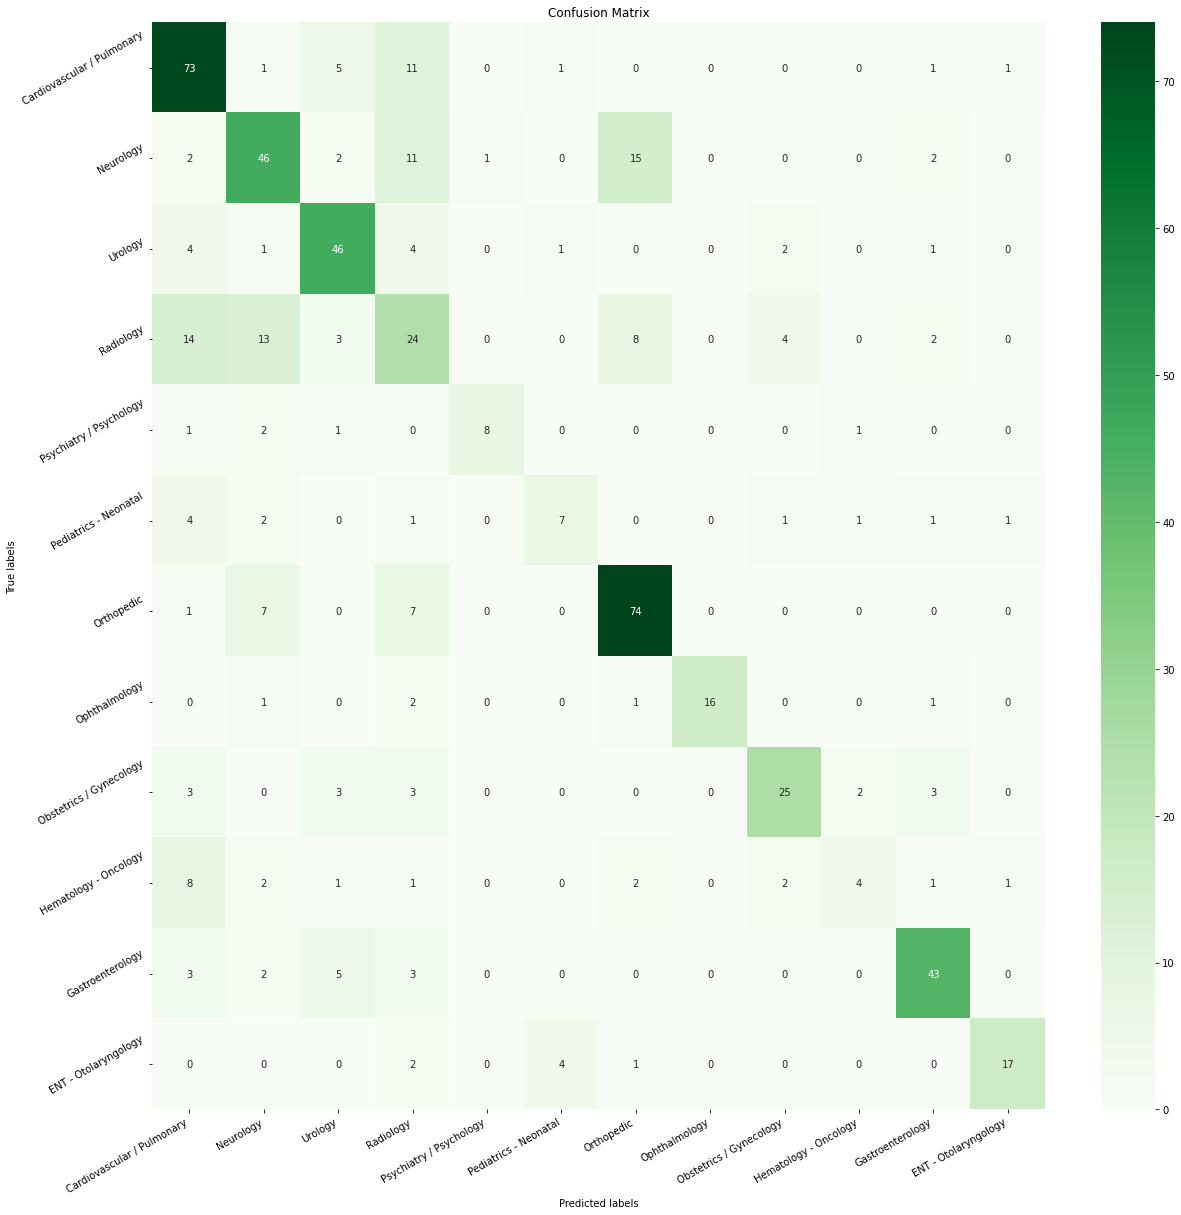

In [ ]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels= category_list)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()


In [ ]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.65      0.78      0.71        93
                 Neurology       0.60      0.58      0.59        79
                   Urology       0.70      0.78      0.74        59
                 Radiology       0.35      0.35      0.35        68
   Psychiatry / Psychology       0.89      0.62      0.73        13
     Pediatrics - Neonatal       0.54      0.39      0.45        18
                Orthopedic       0.73      0.83      0.78        89
             Ophthalmology       1.00      0.76      0.86        21
   Obstetrics / Gynecology       0.74      0.64      0.68        39
     Hematology - Oncology       0.50      0.18      0.27        22
          Gastroenterology       0.78      0.77      0.77        56
      ENT - Otolaryngology       0.85      0.71      0.77        24

                  accuracy                           0.66       581
                 macro avg       0.69      0.6